In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sksurv.util import Surv 
from sklearn.model_selection import train_test_split

In [2]:
import yaml
from functions import *

# Step 1: Parse the YAML file
with open('config.yaml', 'r') as file:
    config_data = yaml.safe_load(file)


###Data API

apikey = config_data['apikey']

headers = config_data['headers']

search_endpoint = config_data['search_endpoint']

data_dir = config_data['data_dir']

    
###CONFIGURATION

data_ingredient = config_data['data_requests']['data_ingredient']

predictions_ingredient = config_data['data_requests']['predictions_ingredient']

data_hazard = config_data['data_requests']['data_hazard']

predictions_hazard = config_data['data_requests']['predictions_hazard']



#####

THRESHOLD_PERCENTILE = config_data['THRESHOLD_PERCENTILE']

timesteps = config_data['timesteps']

random_state = config_data['random_state']

Column_name = config_data['Column_name']

test_size_ = config_data['test_size_']

shuffle_ = config_data['shuffle_']

invalid_observations_removal = config_data['invalid_observations_removal']

interval = config_data['interval'] 

starting_date = config_data['starting_date']

end_date = config_data['end_date']

validation_rows = len(data_prediction_request(apikey, headers, search_endpoint, data_dir, predictions_ingredient, predictions_hazard, interval, starting_date, end_date))

In [3]:
data = pd.read_csv('/home/gmarinos/Documents/Code/Survival_analysis_exceedance_forecasting/synthetic_dataset.csv').rename(columns={'Unnamed: 0':'Date', 'Series 1':'Incidents'})
data = data.drop(columns=['Series 2', 'Series 3'])
data.head()

,Date,Incidents
0,2022-01-31,NaN
1,2022-02-28,NaN
2,2022-03-31,NaN
3,2022-04-30,NaN
4,2022-05-31,NaN


Incidents 16074


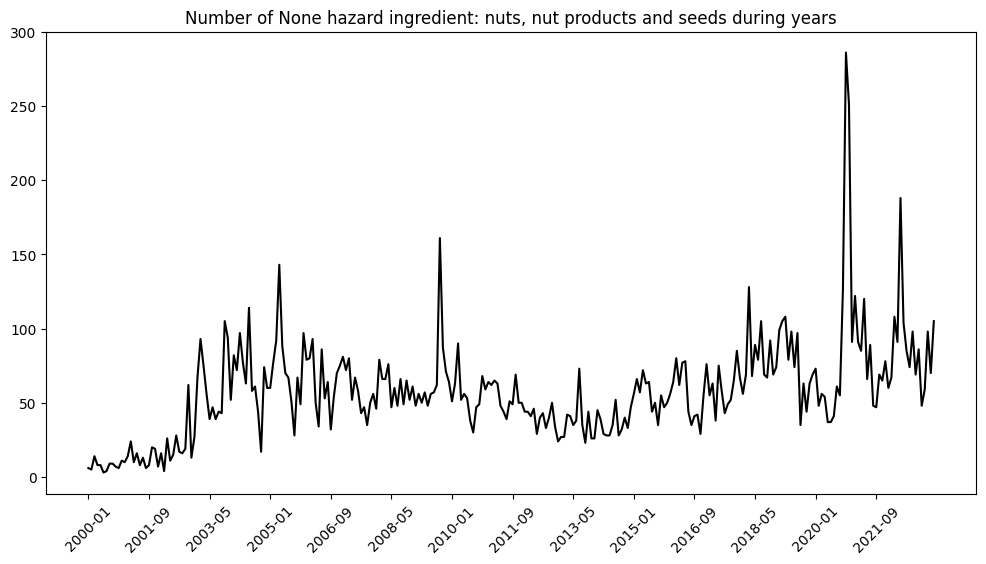

        Date  Incidents
0    2000-01          6
1    2000-02          5
2    2000-03         14
3    2000-04          8
4    2000-05          8
..       ...        ...
275  2022-12         48
276  2023-01         59
277  2023-02         98
278  2023-03         70
279  2023-04        105

[280 rows x 2 columns]
            Predicted_value
Date                       
2021-10-01        60.671082
2021-11-01        61.374947
2021-12-01        58.511398
2022-01-01        65.395554
2022-02-01        75.000000
2022-03-01        68.000000
2022-04-01       107.000000
2022-05-01        59.000000
2022-06-01        84.000000
2022-07-01        56.474709
2022-08-01        58.747616
2022-09-01        91.009193
2022-10-01        67.246376
2022-11-01        58.347767
2022-12-01        87.267227
2023-01-01        71.294487
2023-02-01        93.305328
2023-03-01        61.318035
2023-04-01        81.011528


In [4]:
#get the data
data = data_request(apikey, headers, search_endpoint, data_dir, data_ingredient, data_hazard, interval, starting_date, end_date, plot=True)
prophet_predictions = data_prediction_request(apikey, headers, search_endpoint, data_dir, predictions_ingredient, predictions_hazard, interval, starting_date, end_date)
print(data)
print(prophet_predictions)

In [5]:
list_of_choices = {'data_ingredient':data_ingredient, 
                   'data_hazard':data_hazard, 
                   'predictions_ingredient':predictions_ingredient, 
                   'predictions_hazard':predictions_hazard}

keys_to_remove = []  # Create a list to store keys to remove

for key, value in list_of_choices.items():
    if value == None:
        keys_to_remove.append(key)

    if value == "NONE":
        keys_to_remove.append(key)

    if value == 'None':
        keys_to_remove.append(key)

# Iterate over the keys to remove and delete corresponding items from the dictionary
for key in keys_to_remove:
    del list_of_choices[key]


ingredient = ''

for key, value in list_of_choices.items():
    ingredient += str(key)+':'+str(value)+' _ '

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    
    """
    A class for preprocessing time series data for machine learning and survival analysis tasks.

    Parameters:
    - data (DataFrame): The input data containing timestamped records and target columns.
    - timesteps (int): The number of consecutive time steps to include in each sequence.
    - target_column (str): The name of the target column to predict.
    - interval (str): The time interval for data aggregation, either "WEEK" or "MONTH".

    Methods:
    - create_supervised_data(data, timesteps, target_column, interval):
      Preprocesses the input data, aggregates it based on the specified interval, and creates supervised learning sequences.

    - train_test_split_(data, test_size_):
      Splits the preprocessed data into training and testing sets for machine learning tasks.
      
    - invalid_observations_removal_(X_train, X_test, y_train, y_test, THRESHOLD, invalid_observations_removal):
      Optionally removes invalid observations based on a threshold.

    Usage Example:
    data_processor = DataPreprocessing(my_data, timesteps=5, target_column='Incidents', interval='WEEK')
    X, y = data_processor.create_supervised_data()
    X_train, X_test, y_train, y_test, _, _, _, _, _, _, _, _ = data_processor.train_test_split_(test_size=0.2)
    X_train, X_test, y_train, y_test = data_processor.invalid_observations_removal_(X_train, X_test, y_train, y_test, THRESHOLD=0.5, invalid_observations_removal=True)
    """

    def __init__(self, data, timesteps, target_column, interval):
        self.data = data
        self.timesteps = timesteps
        self.target_column = target_column
        self.interval = interval

    def create_supervised_data(self):
        data = self.data.fillna(0)

        if self.interval == "WEEK":
            if 'Date' in data.columns:
                data['Date'] = pd.to_datetime(data['Date'])
                data['DayOffset'] = data.groupby('Date').cumcount() * 6
                data['Date_week'] = data['Date'] + pd.to_timedelta(data['DayOffset'], unit='D')
                data = data.drop(columns=['Date'])
                data.rename(columns={'Date_week': 'Date'}, inplace=True)
                data = data.set_index('Date')

        elif self.interval == "MONTH":
            if 'Date' in data.columns:
                data['Date'] = pd.to_datetime(data['Date'])
                data = data.set_index('Date')

        sequences = []
        labels = []

        for i in range(len(data) - self.timesteps):
            sequence = data[self.target_column][i:i+self.timesteps]
            target = data[self.target_column][i+self.timesteps]
            sequences.append(sequence.values)
            labels.append(target)

        self.X = pd.DataFrame(sequences, columns=[f'lag_{i+1}' for i in range(self.timesteps)])
        self.y = pd.Series(labels, name='y')

        return self.X, self.y

    def train_test_split(self, test_size_):
        data = self.data.copy()  # Make a copy to avoid modifying the original data
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.set_index('Date')

        if test_size_ == 0:
            X_train = self.X[:-validation_rows]
            y_train, y_test = self.y[:-validation_rows], self.y[-validation_rows:]
            X_test = self.X[-validation_rows:]

            THRESHOLD = np.quantile(y_train, THRESHOLD_PERCENTILE)
            data['extreme_event'] = data['Incidents'].apply(lambda x: 1 if x > THRESHOLD else 0)

            new_df = duration_calculation(timesteps, data, columns=[Column_name, 'extreme_event'])
            X_train_survival = new_df[:-validation_rows].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
            X_test_survival = new_df[-validation_rows:].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
            y_train_survival = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[:-validation_rows].drop(columns=['real_value']))
            y_test_survival = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[-validation_rows:].drop(columns=['real_value']))

            features_df = extract_features(data, timesteps=timesteps)
            new_df_ext_feat_ = alter_duration_calculation(timesteps, data, columns=[Column_name, 'extreme_event'])
            new_df_ext_feat = new_df_ext_feat_.iloc[:, timesteps:]
            for i, column in enumerate(features_df.columns):
                new_df_ext_feat.insert(i, column, value=features_df[column])
            new_df_ext_feat.fillna(0, inplace=True)
            X_train_survival_ext_feat = new_df_ext_feat[:-validation_rows].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
            X_test_survival_ext_feat = new_df_ext_feat[-validation_rows:].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
            y_train_survival_ext_feat = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df_ext_feat[:-validation_rows].drop(columns=['real_value']))
            y_test_survival_ext_feat = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df_ext_feat[-validation_rows:].drop(columns=['real_value']))

            return X_train, X_test, y_train, y_test, THRESHOLD, X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat

        elif test_size_ != 0:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_, shuffle=shuffle_, random_state=random_state)

            THRESHOLD = np.quantile(y_train, THRESHOLD_PERCENTILE)
            data['extreme_event'] = data['Incidents'].apply(lambda x: 1 if x > THRESHOLD else 0)

            new_df = duration_calculation(timesteps, data, columns=[Column_name, 'extreme_event'])
            X_train_survival, X_test_survival, y_train_survival, y_test_survival = train_test_split(new_df.drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date']), 
                            Surv.from_dataframe(event='extreme_event', time='duration', data=new_df.drop(columns=['real_value'])), 
                            test_size=test_size_, shuffle=shuffle_, random_state=random_state)
            
            features_df = extract_features(data, timesteps=timesteps)
            new_df_ext_feat_ = alter_duration_calculation(timesteps, data, columns=[Column_name, 'extreme_event'])
            new_df_ext_feat = new_df_ext_feat_.iloc[:, timesteps:]
            for i, column in enumerate(features_df.columns):
                new_df_ext_feat.insert(i, column, value=features_df[column])
            new_df_ext_feat.fillna(0, inplace=True)

            X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat =  train_test_split(new_df_ext_feat.drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date']), 
                            Surv.from_dataframe(event='extreme_event', time='duration', data=new_df_ext_feat.drop(columns=['real_value'])), 
                            test_size=test_size_, shuffle=shuffle_, random_state=random_state)
            
            return X_train, X_test, y_train, y_test, THRESHOLD, X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat

    def invalid_observations_removal(self, X_train, X_test, y_train, y_test, THRESHOLD, invalid_observations_removal):
        if invalid_observations_removal:
            X_train, y_train = remove_invalid_observations(X=pd.DataFrame(X_train, columns=[f'lag_{i+1}' for i in range(self.timesteps)]),
                                                        y=y_train,
                                                        lag_columns=pd.DataFrame(X_train, columns=[f'lag_{i+1}' for i in range(self.timesteps)]).columns,
                                                        decision_thr=THRESHOLD)
            X_test, y_test = remove_invalid_observations(X=pd.DataFrame(X_test, columns=[f'lag_{i+1}' for i in range(self.timesteps)]),
                                                        y=y_test,
                                                        lag_columns=pd.DataFrame(X_test, columns=[f'lag_{i+1}' for i in range(self.timesteps)]).columns,
                                                        decision_thr=THRESHOLD)
        elif invalid_observations_removal == 'Only_from_train':
            X_train, y_train = remove_invalid_observations(X=pd.DataFrame(X_train, columns=[f'lag_{i+1}' for i in range(self.timesteps)]),
                                                        y=y_train,
                                                        lag_columns=pd.DataFrame(X_train, columns=[f'lag_{i+1}' for i in range(self.timesteps)]).columns,
                                                        decision_thr=THRESHOLD)

        return X_train, X_test, y_train, y_test

In [30]:
# Create an instance of the DataPreprocessing class
data_processor = DataPreprocessor(data, timesteps, Column_name, interval)

# Step 1: Data Preprocessing
X, y = data_processor.create_supervised_data()

# Step 2: Train-Test Split
test_size_ = 0.2  # Set your test size
X_train, X_test, y_train, y_test, THRESHOLD, X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat = data_processor.train_test_split(test_size_)

# Step 3: Invalid Observations Removal (optional)
invalid_observations_removal = False  # Set to True if you want to remove invalid observations
X_train, X_test, y_train, y_test = data_processor.invalid_observations_removal(X_train, X_test, y_train, y_test, THRESHOLD, invalid_observations_removal)

# Now, you have your preprocessed data ready for further analysis or modeling
# You can use X_train, X_test, y_train, and y_test in your machine learning models
# You also have survival analysis datasets if needed: X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat

# Example: Print the first few rows of X_train and y_train
print("X_train:")
print(X_train_survival.head())

print("\ny_train:")
print(y_train.head())

            Incidents  extreme_event
Date                                
2000-01-01          6              0
2000-02-01          5              0
2000-03-01         14              0
2000-04-01          8              0
2000-05-01          8              0
...               ...            ...
2022-12-01         48              0
2023-01-01         59              0
2023-02-01         98              1
2023-03-01         70              0
2023-04-01        105              1

[280 rows x 2 columns]


            Incidents  extreme_event
Date                                
2000-01-01          6              0
2000-02-01          5              0
2000-03-01         14              0
2000-04-01          8              0
2000-05-01          8              0
...               ...            ...
2022-12-01         48              0
2023-01-01         59              0
2023-02-01         98              1
2023-03-01         70              0
2023-04-01        105              1

[280 rows x 2 columns]
X_train:
   lag_1  lag_2  lag_3  lag_4  lag_5  lag_6
0      6      5     14      8      8      3
1      5     14      8      8      3      4
2     14      8      8      3      4      9
3      8      8      3      4      9      9
4      8      3      4      9      9      7

y_train:
0    4
1    9
2    9
3    7
4    6
Name: y, dtype: int64


In [34]:
import sklearn 
import pickle 
import numpy as np
import pandas as pd
import io 
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from scipy.stats import norm, laplace, logistic, gumbel_r, lognorm, cauchy, genextreme 
from hmmlearn import hmm
from functions import *
from sksurv.ensemble import ExtraSurvivalTrees, RandomSurvivalForest
from sksurv.util import Surv
from lightgbm import LGBMRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from tabulate import tabulate


class ModelEvaluator:
    def __init__(self, data, 
                 X_train, X_test, y_train, y_test, THRESHOLD, X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat,
                 target_column, timesteps, THRESHOLD_PERCENTILE,
                 validation_rows, random_state, test_size_, shuffle_, invalid_observations_removal, ingredient, Column_name, interval):
        self.data = data
        self.X_train = X_train 
        self.X_test = X_test 
        self.y_train = y_train 
        self.y_test = y_test 
        self.THRESHOLD = THRESHOLD 
        self.X_train_survival = X_train_survival 
        self.X_test_survival = X_test_survival 
        self.y_train_survival = y_train_survival
        self.y_test_survival = y_test_survival
        self.X_train_survival_ext_feat = X_train_survival_ext_feat
        self.X_test_survival_ext_feat = X_test_survival_ext_feat
        self.y_train_survival_ext_feat = y_train_survival_ext_feat
        self.y_test_survival_ext_feat = y_test_survival_ext_feat
        self.target_column = target_column
        self.timesteps = timesteps
        self.THRESHOLD_PERCENTILE = THRESHOLD_PERCENTILE
        self.validation_rows = validation_rows
        self.random_state = random_state
        self.test_size_ = test_size_
        self.shuffle_ = shuffle_
        self.invalid_observations_removal = invalid_observations_removal
        self.ingredient = ingredient
        self.Column_name = Column_name
        self.interval = interval
        self.list_of_models = [DecisionTreeRegressor(random_state=random_state), 
                               RandomForestRegressor(random_state=random_state), 
                               SGDRegressor(random_state=random_state), 
                               KNeighborsRegressor(n_neighbors=3), 
                               AdaBoostRegressor(random_state=random_state),
                               BayesianRidge(), 
                               ExtraTreesRegressor(random_state=random_state),
                               BaggingRegressor(random_state=random_state), 
                               LGBMRegressor(objective="regression",random_state=random_state),
                               SVR(kernel="linear", C=0.025),
                               SVR(gamma=2, C=1),
                               #GaussianProcessRegressor(1.0 * RBF(1.0), random_state=random_state),
                               MLPRegressor(random_state=random_state),
                               'Prophet',
                               'hidden_markov_models',
                               'Survival_Analysis',
                               'Survival_Analysis_extracted_features',
                               'Prophet_simple_threshold'
                              ]

        self.distributions = [genextreme, norm, laplace, logistic, gumbel_r, lognorm, cauchy]
        self.table_data = []
        self.trained_regressors = {}
        self.results = pd.DataFrame(index=self.y_test.index)
                

    def evaluate_models(self):
        # Loop through models and distributions and evaluate each one
        for regression in self.list_of_models:
            for distribution in self.distributions:
                if regression not in ['Prophet', 'Prophet_simple_threshold', 'Survival_Analysis', 'hidden_markov_models', 'Survival_Analysis_extracted_features']:
                    # Implement the model fitting and evaluation logic here
                    print('\n')
                    print('Distribution:', distribution.name)
                    print('Model:', str(regression))

                    regression.fit(self.X_train, self.y_train)

                    self.trained_regressors[str(regression)+'_'+str(distribution.name)]=[regression]

                    # getting point forecasts
                    point_forecasts = regression.predict(X_test)
                    std = y_train.std()
                    if distribution == lognorm:
                        exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, loc=x_, s=std) for x_ in point_forecasts])
                    elif distribution == genextreme:
                        exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, c = -0.1, loc=x_, scale=std) for x_ in point_forecasts])
                    elif distribution != lognorm:
                        exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, loc=x_, scale=std) for x_ in point_forecasts])
                    
                    #y_test_ = new_df['marked'].loc[y_test.index]
                    y_test_ = (self.y_test > THRESHOLD).astype(int)
                    
                    y_pred_binary = np.where(exceedance_prob >= 0.5, 1, 0)
                    self.results['actual_predictions_from_model'+'_'+str(regression)+'_'+str(distribution.name)]  = point_forecasts
                    self.results['y_pred_binary'+'_'+str(regression)+'_'+str(distribution.name)]  = y_pred_binary
                    self.trained_regressors[str(regression)+'_'+str(distribution.name)].append(y_pred_binary)

                    # Compute the confusion matrix
                    cm = confusion_matrix(y_test_, y_pred_binary)

                    # Compute the precision, recall, and F1 score
                    accuracy = accuracy_score(y_test_, y_pred_binary)
                    precision = precision_score(y_test_, y_pred_binary)
                    recall = recall_score(y_test_, y_pred_binary)
                    f1 = f1_score(y_test_, y_pred_binary)
                    roc_auc = roc_auc_score(y_test_, exceedance_prob)

                    # Print the results
                    print(f"Confusion Matrix:\n{cm}")
                    print(f"Accuracy: {accuracy:.2f}")
                    print(f"Precision: {precision:.2f}")
                    print(f"Recall: {recall:.2f}")
                    print(f"F1 Score: {f1:.2f}")
                    print(f"Roc AUC: {roc_auc:.2f}")

                    self.trained_regressors[str(regression)+'_'+str(distribution.name)].append([accuracy, precision, recall, f1, roc_auc])

                    self.table_data.append([ingredient+'_'+Column_name, THRESHOLD, timesteps, distribution.name, regression, 
                                        str(int(np.round(accuracy, 2)*100))+str('%'), 
                                        str(int(np.round(precision, 2)*100))+str('%'), 
                                        str(int(np.round(recall, 2)*100))+str('%'), 
                                        str(int(np.round(f1, 2)*100))+str('%'), 
                                        str(int(np.round(roc_auc, 2)*100))+str('%'), 
                                        test_size_, shuffle_, invalid_observations_removal, 
                                        len(X_train.columns), 
                                        interval])
      
                elif regression == 'Prophet' and test_size_ == 0:
                    # Implement Prophet model logic here
                    self.trained_regressors[str(regression)+'_'+str(distribution.name)]=[regression]

                    prophet_predictions = data_prediction_request(apikey, headers, search_endpoint, data_dir, predictions_ingredient, predictions_hazard, interval, starting_date, end_date)
                    predicted_historical_values = prophet_predictions[:validation_rows].values

                    #------------------------------------------
                    #list_of_results = insert_metrics_from_foodakai(predicted_historical_values, y_train, y_test, exceedance_prob, Column_name, 
                    #                       THRESHOLD, timesteps, foodakai_model='Prophet',
                    #                      test_size=test_size_, shuffle=shuffle_, invalid_observations_removal = invalid_observations_removal, 
                    #                      no_of_columns= len(X_train.columns))

                    #for i in list_of_results:
                    #  table_data.append(i)
                    #--------------------------------------------

                    std = y_train.std()
                    if distribution == lognorm:
                        exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, loc=x_, s=std) for x_ in predicted_historical_values])
                    elif distribution == genextreme:
                        exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, c = -0.1, loc=x_, scale=std) for x_ in predicted_historical_values])
                    elif distribution != lognorm:
                        exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, loc=x_, scale=std) for x_ in predicted_historical_values])

                    y_test_ = (y_test > THRESHOLD).astype(int)
                    y_pred_binary = np.where(exceedance_prob >= 0.5, 1, 0)

                    self.trained_regressors[str(regression)+'_'+str(distribution.name)].append(y_pred_binary)

                    self.results['actual_predictions_from_model'+'_'+str(regression)]  = predicted_historical_values
                    self.results['y_pred_binary'+'_'+str(regression)+'_'+str(distribution.name)]  = y_pred_binary

                    # Calculate metrics
                    accuracy = accuracy_score(y_test_, y_pred_binary)
                    precision = precision_score(y_test_, y_pred_binary)
                    recall = recall_score(y_test_, y_pred_binary)
                    f1 = f1_score(y_test_, y_pred_binary)
                    roc_auc = roc_auc_score(y_test_, exceedance_prob)

                    self.table_data.append([ingredient+'_'+Column_name, THRESHOLD, timesteps, distribution.name, regression, 
                                        str(int(np.round(accuracy, 2)*100))+str('%'), 
                                        str(int(np.round(precision, 2)*100))+str('%'), 
                                        str(int(np.round(recall, 2)*100))+str('%'), 
                                        str(int(np.round(f1, 2)*100))+str('%'), 
                                        str(int(np.round(roc_auc, 2)*100))+str('%'), 
                                        test_size_, shuffle_, invalid_observations_removal, 
                                        len(X_train.columns), 
                                        interval])

                    self.trained_regressors[str(regression)+'_'+str(distribution.name)].append([accuracy, precision, recall, f1, roc_auc])

                else:
                    pass

            if regression == 'hidden_markov_models' and test_size_ == 0:
                # Implement HMM model logic here
                print('\n')
                print('Model:', str(regression))

                self.trained_regressors[str(regression)]=[regression]

                # Initialize the HMM model
                model = hmm.CategoricalHMM(n_components=2, random_state=33)

                observed_window = data['Incidents'][:-validation_rows]

                # Encode the observed values based on the threshold
                binary_sequence = np.array(observed_window > THRESHOLD, dtype=int)

                # Preprocess the data to handle missing or invalid values
                binary_sequence[np.isnan(binary_sequence)] = 0  # Replace NaN values with 0

                # Fit the model to the current observed window
                model.fit(binary_sequence.reshape(-1, 1))

                # Forecast the next hidden state
                num_steps = len(data[-validation_rows:])  # Number of future steps to forecast
                future_hidden_states, _ = model.sample(num_steps)

                y_test_ = (y_test > THRESHOLD).astype(int)

                y_pred_binary = future_hidden_states

                # Compute the confusion matrix
                cm = confusion_matrix(y_test_, y_pred_binary)

                # Calculate metrics
                accuracy = accuracy_score(y_test_, y_pred_binary)
                precision = precision_score(y_test_, y_pred_binary)
                recall = recall_score(y_test_, y_pred_binary)
                f1 = f1_score(y_test_, y_pred_binary)
                roc_auc = roc_auc_score(y_test_, y_pred_binary)

                # Print the results
                print(f"Confusion Matrix:\n{cm}")
                print(f"Accuracy: {accuracy:.2f}")
                print(f"Precision: {precision:.2f}")
                print(f"Recall: {recall:.2f}")
                print(f"F1 Score: {f1:.2f}")
                print(f"Roc AUC: {roc_auc:.2f}")

                self.trained_regressors[str(regression)].append(y_pred_binary)

                self.results['actual_predictions_from_model'+'_'+str(regression)]  = predicted_historical_values
                self.results['y_pred_binary'+'_'+str(regression)]  = y_pred_binary

                self.table_data.append([ingredient+'_'+Column_name, THRESHOLD, timesteps, None, regression, 
                                    str(int(np.round(accuracy, 2)*100))+str('%'), 
                                    str(int(np.round(precision, 2)*100))+str('%'), 
                                    str(int(np.round(recall, 2)*100))+str('%'), 
                                    str(int(np.round(f1, 2)*100))+str('%'), 
                                    str(int(np.round(roc_auc, 2)*100))+str('%'), 
                                    test_size_, shuffle_, invalid_observations_removal, 
                                    len(X_train.columns), 
                                    interval])

                self.trained_regressors[str(regression)].append([accuracy, precision, recall, f1, roc_auc])
                


            if regression == 'Survival_Analysis':
                # Implement Survival Analysis logic here
                self.trained_regressors[str(regression)]=[regression]

                scores_cph_tree = {}
                scores_RandomSurvivalForest = {} 

                est_cph_tree = RandomSurvivalForest(random_state=random_state)
                for i in range(1, 61):
                    n_estimators = i * 5
                    est_cph_tree.set_params(n_estimators=n_estimators)
                    est_cph_tree.fit(X_train_survival, y_train_survival)
                    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test_survival, y_test_survival)
                    scores_RandomSurvivalForest['scores_cph_tree'+str(n_estimators)] =  pickle.dumps(est_cph_tree)
                

                metrics = []
                prob_percentages = [0.85, 0.90]

                for i in range(5, 61, 5):
                    for prob_percentage in prob_percentages:
                        list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict_survival_function(X_test_survival, return_array=True)

                        y_test_ = (y_test_survival['extreme_event'] == True).astype(int)
                        y_pred_binary = pd.DataFrame(list_of_lists[0:,0], columns=['probabilities'])['probabilities'].apply(lambda x: 1 if x < prob_percentage else 0).values

                        # Calculate metrics
                        accuracy = accuracy_score(y_test_, y_pred_binary)
                        precision = precision_score(y_test_, y_pred_binary)
                        recall = recall_score(y_test_, y_pred_binary)
                        f1 = f1_score(y_test_, y_pred_binary)
                        roc_auc = roc_auc_score(y_test_, list_of_lists[0:,0])
                        

                        metrics.append({'model':'scores_cph_tree'+str(i),
                                        'accuracy': accuracy,
                                        'precision': precision,
                                        'recall': recall,
                                        'roc_auc':roc_auc,
                                        'f1-score':f1,
                                        'y_pred_binary':y_pred_binary})

                        print(accuracy,'%', precision,'%', recall,'%', f1,'%', roc_auc,'%')

                # Sort the list based on the 'age' field
                sorted_data = sorted(metrics, key=lambda x: x['f1-score'], reverse=True)

                accuracy = sorted_data[0]['accuracy']
                precision = sorted_data[0]['precision']
                recall = sorted_data[0]['recall']    
                f1 = sorted_data[0]['f1-score']
                roc_auc = sorted_data[0]['roc_auc']

                self.trained_regressors[str(regression)].append(y_pred_binary)
                
                self.table_data.append([ingredient+'_'+Column_name, THRESHOLD, timesteps, None, 
                                    regression+'_'+str(sorted_data[0]['model']), 
                                    str(int(np.round(accuracy,2)*100))+str('%'), 
                                    str(int(np.round(precision,2)*100))+str('%'), 
                                    str(int(np.round(recall,2)*100))+str('%'), 
                                    str(int(np.round(f1,2)*100))+str('%'), 
                                    str(int(np.round(roc_auc,2)*100))+str('%'), 
                                    test_size_, shuffle_, invalid_observations_removal, 
                                    len(X_train_survival.columns), 
                                    interval])

                
                self.trained_regressors[str(regression)].append([accuracy, precision, recall, f1, roc_auc])


            if regression == 'Survival_Analysis_extracted_features':
                # Implement Survival Analysis with extracted features logic here
                self.trained_regressors[str(regression)]=[regression]

                scores_cph_tree = {}
                scores_RandomSurvivalForest = {} 

                est_cph_tree = RandomSurvivalForest(random_state=random_state)
                for i in range(1, 61):
                    n_estimators = i * 5
                    est_cph_tree.set_params(n_estimators=n_estimators)
                    est_cph_tree.fit(X_train_survival_ext_feat, y_train_survival_ext_feat)
                    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test_survival_ext_feat, y_test_survival_ext_feat)
                    scores_RandomSurvivalForest['scores_cph_tree'+str(n_estimators)] =  pickle.dumps(est_cph_tree)
                

                metrics = []
                prob_percentages = [0.85, 0.90]

                for i in range(5, 61, 5):
                    for prob_percentage in prob_percentages:
                        list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict_survival_function(X_test_survival_ext_feat, return_array=True)

                        y_test_ = (y_test_survival_ext_feat['extreme_event'] == True).astype(int)
                        y_pred_binary = pd.DataFrame(list_of_lists[0:,8], columns=['probabilities'])['probabilities'].apply(lambda x: 1 if x < prob_percentage else 0).values

                        # Calculate metrics
                        accuracy = accuracy_score(y_test_, y_pred_binary)
                        precision = precision_score(y_test_, y_pred_binary)
                        recall = recall_score(y_test_, y_pred_binary)
                        f1 = f1_score(y_test_, y_pred_binary)
                        roc_auc = roc_auc_score(y_test_, list_of_lists[0:,8])
                        

                        metrics.append({'model':'scores_cph_tree'+str(i),
                                        'accuracy': accuracy,
                                        'precision': precision,
                                        'recall': recall,
                                        'roc_auc':roc_auc,
                                        'f1-score':f1,
                                        'y_pred_binary':y_pred_binary})

                        print(accuracy,'%', precision,'%', recall,'%', f1,'%', roc_auc,'%')

                # Sort the list based on the 'age' field
                sorted_data = sorted(metrics, key=lambda x: x['f1-score'], reverse=True)

                accuracy = sorted_data[0]['accuracy']
                precision = sorted_data[0]['precision']
                recall = sorted_data[0]['recall']    
                f1 = sorted_data[0]['f1-score']
                roc_auc = sorted_data[0]['roc_auc']

                self.trained_regressors[str(regression)].append(y_pred_binary)
                
                self.table_data.append([ingredient+'_'+Column_name, THRESHOLD, timesteps, None, 
                                    regression+'_'+str(sorted_data[0]['model']), 
                                    str(int(np.round(accuracy,2)*100))+str('%'), 
                                    str(int(np.round(precision,2)*100))+str('%'), 
                                    str(int(np.round(recall,2)*100))+str('%'), 
                                    str(int(np.round(f1,2)*100))+str('%'), 
                                    str(int(np.round(roc_auc,2)*100))+str('%'), 
                                    test_size_, shuffle_, invalid_observations_removal, 
                                    len(X_train_survival_ext_feat.columns), 
                                    interval])

                
                self.trained_regressors[str(regression)].append([accuracy, precision, recall, f1, roc_auc])




            if regression == 'Prophet_simple_threshold' and test_size_ == 0:
                # Implement Prophet model with threshold logic here
                self.trained_regressors[str(regression)]=[regression]

                #-----------------------------
                #results_ = insert_metrics_from_foodakai_simple_threshold(predicted_historical_values, y_train, y_test, exceedance_prob, 
                #                       Column_name, THRESHOLD, timesteps, foodakai_model='Prophet',
                #                      test_size=test_size_, shuffle=shuffle_, invalid_observations_removal = invalid_observations_removal, 
                #                      no_of_columns= len(X_train.columns))

                #table_data.append(results_)
                #-----------------------------

                y_test_ = (y_test > THRESHOLD).astype(int)
                y_pred_binary = (predicted_historical_values > THRESHOLD).astype(int)
                
                self.trained_regressors[str(regression)].append(y_pred_binary)

                self.results['actual_predictions_from_model'+'_'+str(regression)]  = predicted_historical_values
                self.results['y_pred_binary'+'_'+str(regression)]  = y_pred_binary

                # Calculate metrics
                accuracy = accuracy_score(y_test_, y_pred_binary)
                precision = precision_score(y_test_, y_pred_binary)
                recall = recall_score(y_test_, y_pred_binary)
                f1 = f1_score(y_test_, y_pred_binary)
                roc_auc = roc_auc_score(y_test_, y_pred_binary)

                self.table_data.append([ingredient+'_'+Column_name, THRESHOLD, timesteps, None, regression, 
                                    str(int(np.round(accuracy, 2)*100))+str('%'), 
                                    str(int(np.round(precision, 2)*100))+str('%'), 
                                    str(int(np.round(recall, 2)*100))+str('%'), 
                                    str(int(np.round(f1, 2)*100))+str('%'), 
                                    str(int(np.round(roc_auc, 2)*100))+str('%'), 
                                    test_size_, shuffle_, invalid_observations_removal, 
                                    len(X_train.columns), 
                                    interval])

                
                self.trained_regressors[str(regression)].append([accuracy, precision, recall, f1, roc_auc])

        
    
    
    def print_results(self):
        # Print results and display the table
        print(tabulate(self.table_data, headers=["Data", "Threshold", "Number of lags", "Distribution", "Algorithm", 
                                    "Accuracy", "Precision", "Recall", "F1-score", 'Roc AUC', 'Test size', 'Shuffle', 
                                    'Invalid Observations removal', 'No of Columns', 'Resolution'], tablefmt="grid"))
        
        self.table_str = tabulate(self.table_data, headers=["Data", "Threshold", "Number of lags", "Distribution", "Algorithm", 
                                    "Accuracy", "Precision", "Recall", "F1-score", 'Roc AUC', 'Test size', 'Shuffle', 
                                    'Invalid Observations removal', 'No of Columns', 'Resolution'], tablefmt="pipe")
        return self.table_str

    def get_results_df(self):
        # Return the results dataframe
        df = pd.read_csv(io.StringIO(self.table_str), sep="|")
        df.to_csv('results/performance_results/performance_results'+'_'+ingredient+'_'+'threshold'+'_'+str(np.round(THRESHOLD,0))+'.'+'csv', index=False)
        self.results.to_csv('results/combined_results/results'+'_'+ingredient+'_'+'threshold'+'_'+str(np.round(THRESHOLD,0))+'.'+'csv')


In [35]:
model_evaluator = ModelEvaluator(data, 
                                  X_train, X_test, y_train, y_test, THRESHOLD, X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat,
                                  Column_name, timesteps, THRESHOLD_PERCENTILE,
                                   validation_rows, random_state, test_size_, shuffle_,
                                   invalid_observations_removal, ingredient, Column_name, interval)

In [36]:
table_data = model_evaluator.evaluate_models()
model_evaluator.print_results()



Distribution: genextreme
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[23  8]
 [18  6]]
Accuracy: 0.53
Precision: 0.43
Recall: 0.25
F1 Score: 0.32
Roc AUC: 0.67


Distribution: norm
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[28  3]
 [18  6]]
Accuracy: 0.62
Precision: 0.67
Recall: 0.25
F1 Score: 0.36
Roc AUC: 0.67


Distribution: laplace
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[28  3]
 [18  6]]
Accuracy: 0.62
Precision: 0.67
Recall: 0.25
F1 Score: 0.36
Roc AUC: 0.67


Distribution: logistic
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[28  3]
 [18  6]]
Accuracy: 0.62
Precision: 0.67
Recall: 0.25
F1 Score: 0.36
Roc AUC: 0.67


Distribution: gumbel_r
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[23  8]
 [18  6]]
Accuracy: 0.53
Precision: 0.43
Recall: 0.25
F1 Score: 0.32
Roc AUC: 0.67


Distribution: lognorm
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[28  3]
 

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:3263: RuntimeWarning: overflow encountered in exp
  return np.exp(-np.exp(-x))


Confusion Matrix:
[[19 12]
 [ 7 17]]
Accuracy: 0.65
Precision: 0.59
Recall: 0.71
F1 Score: 0.64
Roc AUC: 0.80


Distribution: norm
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[30  1]
 [21  3]]
Accuracy: 0.60
Precision: 0.75
Recall: 0.12
F1 Score: 0.21
Roc AUC: 0.80


Distribution: laplace
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[30  1]
 [21  3]]
Accuracy: 0.60
Precision: 0.75
Recall: 0.12
F1 Score: 0.21
Roc AUC: 0.80


Distribution: logistic
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[30  1]
 [21  3]]
Accuracy: 0.60
Precision: 0.75
Recall: 0.12
F1 Score: 0.21
Roc AUC: 0.80


Distribution: gumbel_r
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[19 12]
 [ 7 17]]
Accuracy: 0.65
Precision: 0.59
Recall: 0.71
F1 Score: 0.64
Roc AUC: 0.80


Distribution: lognorm
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[30  1]
 [19  5]]
Accuracy: 0.64
Precision: 0.83
Recall: 0.21
F1 Score: 0.33
Roc AUC: 0.79


Distribut

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Confusion Matrix:
[[20 11]
 [ 3 21]]
Accuracy: 0.75
Precision: 0.66
Recall: 0.88
F1 Score: 0.75
Roc AUC: 0.79


Distribution: norm
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[24  7]
 [ 8 16]]
Accuracy: 0.73
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
Roc AUC: 0.79


Distribution: laplace
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[24  7]
 [ 8 16]]
Accuracy: 0.73
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
Roc AUC: 0.79


Distribution: logistic
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[24  7]
 [ 8 16]]
Accuracy: 0.73
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
Roc AUC: 0.79


Distribution: gumbel_r
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[20 11]
 [ 3 21]]
Accuracy: 0.75
Precision: 0.66
Recall: 0.88
F1 Score: 0.75
Roc AUC: 0.79


Distribution: lognorm
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[22  9]
 [ 8 16]]
Accuracy: 0.69
Precision: 0.64
Recall: 0.67
F1 Score: 0.65
Roc AUC: 0.78


Distribution: cauchy
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[24  7]
 [ 8 16]]
Accuracy: 0.73
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
Roc AUC: 0.79
0.6545454545454545 % 1.0 % 0.20833333333333334 % 0.3448275862068966 % 0.282258064516129 %
0.6727272727272727 % 1.0 % 0.25 % 0.4 % 0.282258064516129 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.2264784946236559 %
0.6727272727272727 % 0.8 % 0.3333333333333333 % 0.47058823529411764 % 0.2264784946236559 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.2264784946236559 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.2264784946236559 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.24731182795698925 %
0.6545454545454545 % 0.8571428571428571 % 0.25 % 0.3870967741935483 % 0.24731182795698925 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.2547043010752688 %
0.6545454545454545 % 

"| Data                                                                                                            |   Threshold |   Number of lags | Distribution   | Algorithm                                              | Accuracy   | Precision   | Recall   | F1-score   | Roc AUC   |   Test size | Shuffle   | Invalid Observations removal   |   No of Columns | Resolution   |\n|:----------------------------------------------------------------------------------------------------------------|------------:|-----------------:|:---------------|:-------------------------------------------------------|:-----------|:------------|:---------|:-----------|:----------|------------:|:----------|:-------------------------------|----------------:|:-------------|\n| data_ingredient:nuts, nut products and seeds _ predictions_ingredient:nuts, nut products and seeds _ _Incidents |          80 |                6 | genextreme     | DecisionTreeRegressor(random_state=33)                 | 53%        | 43%  

In [38]:
model_evaluator.get_results_df()